# Problem Description: Darcy Flow

**Governing Equation: $\quad Q = -K\cdot A \cdot \frac{\Delta h}{L}$**

$Q$ (Flow Rate): 단위 시간당 흐르는 유체의 부피 ($m^3/s$) </br>
$K$ (Hydraulic Conductivity): 투수 계수. 매질이 유체를 얼마나 잘 통과시키는지를 나타내는 고유 속성입니다.</br>
$A$ (Cross-sectional Area): 유체가 통과하는 단면적 ($m^2$)$\Delta h$ (Head Loss): 두 지점 사이의 수두(에너지) 차이 ($m$)</br>
$L$ (Length): 유체가 이동한 경로의 길이 ($m$)</br>
$\frac{\Delta h}{L}$ (Hydraulic Gradient): 수력 경사. 단위 길이당 수두 손실을 의미합니다.

**Boundary Condition: $\quad u_{bc}(x,y) = 0, \quad x,y \in [0,1]$**

**PDE: $\quad −∇⋅(k(x,y)∇u(x,y))=f(x,y),x∈[0,1]$**

**Solution Operator: $G : k(x,y) \mapsto u(x,y)$**

branch net 입력: k(x,y)의 센서값</br>
trunk net 입력: x,y 그리드 좌표</br>
출력: 전체 압력장 u(x,y)

Reference: https://neuraloperator.github.io/dev/auto_examples/data/plot_darcy_flow.html#sphx-glr-download-auto-examples-data-plot-darcy-flow-py

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def convert_np_to_tensor(array):
  if isinstance(array, np.ndarray):
    # Convert NumPy array to PyTorch tensor
    tensor = torch.from_numpy(array)
    return tensor.to(torch.float32)
  else:
    return array

In [5]:
d =  np.load("C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_bc.npz",allow_pickle=True)
branch_np, trunk_np, Y_np = d["branch"], d["trunk"], d["y"]

Y_np_scaled = Y_np * 100

branch   = convert_np_to_tensor(branch_np)
trunk   = convert_np_to_tensor(trunk_np)
Y = convert_np_to_tensor(Y_np_scaled)

print(f'branch shape: {branch.shape}, type: {type(branch)}, dtype: {branch.dtype}')
print(f'trunk shape: {trunk.shape}, type: {type(trunk)}, dtype: {trunk.dtype}')
print(f'Y shape: {Y.shape}, type: {type(Y)}, dtype: {Y.dtype}')

branch shape: torch.Size([100, 400]), type: <class 'torch.Tensor'>, dtype: torch.float32
trunk shape: torch.Size([2500, 2]), type: <class 'torch.Tensor'>, dtype: torch.float32
Y shape: torch.Size([100, 2500]), type: <class 'torch.Tensor'>, dtype: torch.float32


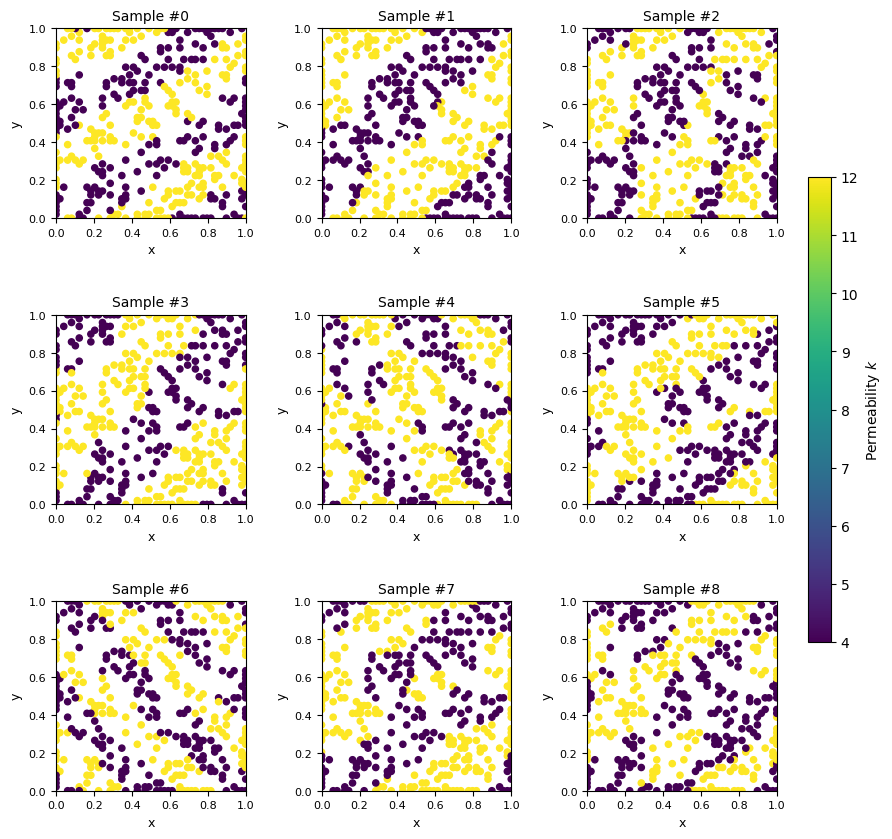

In [6]:
def visualize_k_sensors_3x3(
    file_path,
    save_path="C:/Users/admin/Desktop/김도형/코드/figure_20260206_labmeeting/branch_k_sample.png",
    cmap="viridis"
):
    data = np.load(file_path, allow_pickle=True)

    branch = data["branch"]             # (samples, m_sensors + bc_sensors)
    sensor_ij = data["sensor_ij"]       # (m_sensors, 2)
    bc_sensor_ij = data["bc_sensor_ij"] # (bc_sensors, 2)
    Nx, Ny = int(data["Nx"]), int(data["Ny"])

    m = sensor_ij.shape[0]
    b = bc_sensor_ij.shape[0]

    n_plot = 9  # 3x3 고정
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.45, wspace=0.4)

    kmin = np.nanmin(branch[:n_plot])
    kmax = np.nanmax(branch[:n_plot])

    # 0.2 단위 눈금 설정
    ticks = np.arange(0, 1.1, 0.2)

    for idx in range(n_plot):
        r = idx // 3
        c = idx % 3
        ax = axes[r, c]

        k_interior = branch[idx, :m]
        k_boundary = branch[idx, m:m + b]

        # 좌표 정규화 (0~1 범위)
        # sensor_ij[:, 1]는 x(column), sensor_ij[:, 0]는 y(row)
        s_x, s_y = sensor_ij[:, 1] / (Ny - 1), sensor_ij[:, 0] / (Nx - 1)
        bc_x, bc_y = bc_sensor_ij[:, 1] / (Ny - 1), bc_sensor_ij[:, 0] / (Nx - 1)

        # interior 센서
        sc = ax.scatter(
            s_x, s_y,
            c=k_interior, cmap=cmap, s=20,
            vmin=kmin, vmax=kmax
        )
        # boundary 센서
        ax.scatter(
            bc_x, bc_y,
            c=k_boundary, cmap=cmap, s=20,
            vmin=kmin, vmax=kmax
        )

        ax.set_title(f"Sample #{idx}", fontsize=10)
        
        # 축 범위 및 라벨 설정
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xlabel("x", fontsize=9)
        ax.set_ylabel("y", fontsize=9)
        ax.tick_params(labelsize=8)
        ax.set_aspect("equal")

    # 공통 colorbar
    cbar = fig.colorbar(
        sc, 
        ax=axes.ravel().tolist(), 
        fraction=0.03, 
        pad=0.04, 
        label="Permeability $k$"
    )

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# 실행
visualize_k_sensors_3x3(file_path="C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_bc.npz")

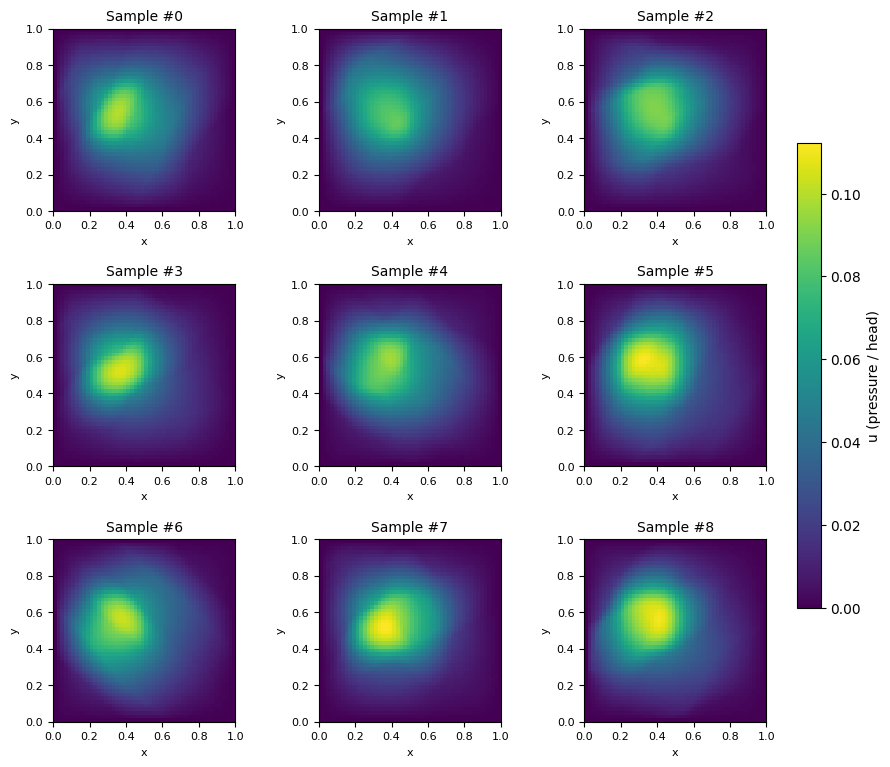

In [ ]:
def visualize_u_3x3(file_path, save_path="C:/Users/admin/Desktop/김도형/코드/figure_20260206_labmeeting/True_u_sample.png", cmap="viridis"):
    data = np.load(file_path, allow_pickle=True)

    u_all = data["y"]           # (samples, Nx*Ny)
    Nx, Ny = int(data["Nx"]), int(data["Ny"])

    n_plot = 9  # 3x3
    fig, axes = plt.subplots(3, 3, figsize=(10, 9)) # 컬러바 공간을 위해 가로를 살짝 늘림
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # 공통 color scale (비교용)
    umin = np.min(u_all[:n_plot])
    umax = np.max(u_all[:n_plot])

    # imshow용 물리 좌표 범위 [x_min, x_max, y_min, y_max]
    extent_range = [0, 1, 0, 1]

    for idx in range(n_plot):
        r = idx // 3
        c = idx % 3
        ax = axes[r, c]

        u = u_all[idx].reshape(Nx, Ny)

        im = ax.imshow(
            u.T,
            origin="lower",
            cmap=cmap,
            vmin=umin,
            vmax=umax,
            extent=extent_range, # 좌표 범위 설정
            aspect="equal"       # 물리적 형상 유지
        )

        ax.set_title(f"Sample #{idx}", fontsize=10)
        
        # 모든 그래프에 x, y 라벨 추가
        ax.set_xlabel("x", fontsize=8)
        ax.set_ylabel("y", fontsize=8)
        
        # 눈금이 너무 빽빽하지 않게 설정 (0, 0.5, 1 정도만 표시)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.tick_params(labelsize=8)

    # 공통 colorbar
    cbar = fig.colorbar(
        im,
        ax=axes.ravel().tolist(),
        fraction=0.03,
        pad=0.04,
        label="u (pressure / head)"
    )
    
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# 실행
visualize_u_3x3(file_path="C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_bc.npz")

In [ ]:
class Datahandler(Dataset):
  def __init__(self, u_branch, y_trunk, guy):
    self.u_branch = u_branch
    self.y_trunk = y_trunk
    self.guy = guy

  def __len__(self):
    return len(self.guy)

  def __getitem__(self, index):
    return self.u_branch[index,:], self.y_trunk, self.guy[index,:]

torch.Size([100, 2500])

In [ ]:
dataset = Datahandler(branch[:70], trunk, Y[:70])
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 70, shuffle=True)

In [ ]:
class Network(torch.nn.Module):
    def __init__(self, branch_dim=400, trunk_dim=2, hidden_dim=128, output_dim=64):
        super(Network, self).__init__()

        self.bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.branch = nn.Sequential(
            nn.Linear(branch_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, branch, trunk):
        branch_out = self.branch(branch)
        trunk_out  = self.trunk(trunk)
        out = branch_out @ trunk_out.T + self.bias
        return out

def init_weights(m): 
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data) 
        nn.init.zeros_(m.bias)

In [ ]:
model = Network()
model.apply(init_weights)

Network(
  (branch): Sequential(
    (0): Linear(in_features=400, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_history = {'loss':[]}

In [ ]:
n_epochs = 15000
for epoch in range(n_epochs):
  losses = []
  for branch_batch, _, Y_batch in dataloader: 
    optimizer.zero_grad()

    pred = model(branch_batch, trunk)
    loss = loss_fn(pred, Y_batch)

    loss.backward()

    losses.append(loss.item())

    optimizer.step()

  avg_loss = np.mean(losses)
  if epoch%1000 == 0:
    print(f'Epoch: {epoch}, Loss: {float(avg_loss): .2}')

Epoch: 0, Loss:  1.1e+01
Epoch: 1000, Loss:  0.16
Epoch: 2000, Loss:  0.11
Epoch: 3000, Loss:  0.11
Epoch: 4000, Loss:  0.084
Epoch: 5000, Loss:  0.074
Epoch: 6000, Loss:  0.067
Epoch: 7000, Loss:  0.057
Epoch: 8000, Loss:  0.05
Epoch: 9000, Loss:  0.044
Epoch: 10000, Loss:  0.039
Epoch: 11000, Loss:  0.035
Epoch: 12000, Loss:  0.032
Epoch: 13000, Loss:  0.029
Epoch: 14000, Loss:  0.027


In [ ]:
Y.max()

tensor(11.5405)

Sample #90 Relative L2 Error: 19.76%


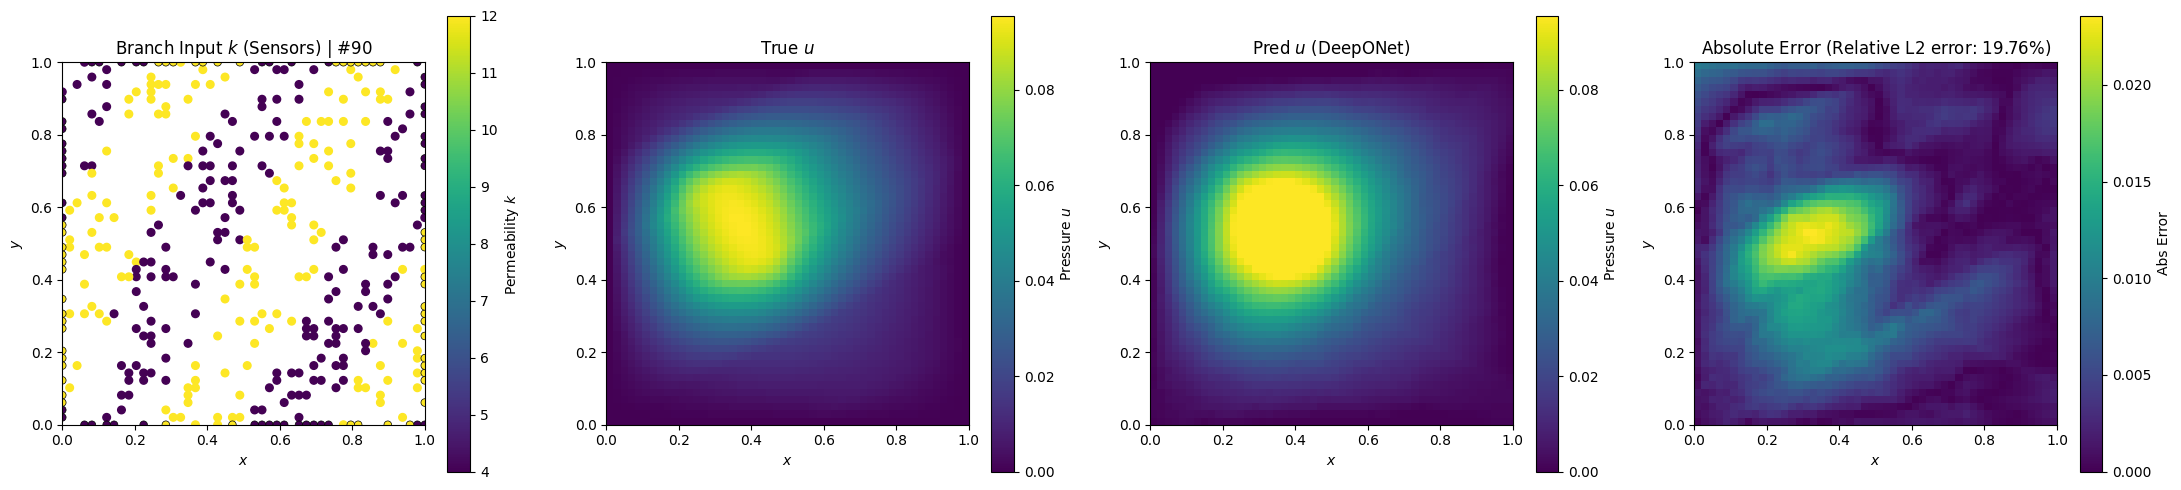

In [ ]:
# --- 1. 환경 설정 및 데이터 로드 ---
idx = 90
scale = 100.0  # 물리 스케일 복구 값
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 경로 (사용자 경로 유지)
data_path = "C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_bc.npz"
d = np.load(data_path, allow_pickle=True)

sensor_ij = d["sensor_ij"]       # Interior 센서 좌표 (indices)
bc_sensor_ij = d["bc_sensor_ij"] # Boundary 센서 좌표 (indices)
Nx, Ny = int(d["Nx"]), int(d["Ny"])

m = sensor_ij.shape[0]
b = bc_sensor_ij.shape[0]

# --- 2. 데이터 추출 및 모델 예측 ---
# Y, branch, trunk, model 등은 메모리에 정의되어 있다고 가정합니다.
model.eval()
model = model.to(device)

with torch.no_grad():
    # True u 복구
    u_true = (Y[idx].detach().cpu().numpy() / scale).reshape(Nx, Ny)
    
    # Branch 입력 분리 (시각화용)
    k_sample = branch[idx].detach().cpu().numpy()
    k_interior = k_sample[:m]
    k_boundary = k_sample[m:m+b]
    
    # 모델 예측
    branch_input = branch[idx:idx+1].to(device)
    trunk_input = trunk.to(device)
    pred_scaled = model(branch_input, trunk_input)
    u_pred = (pred_scaled / scale).squeeze(0).detach().cpu().numpy().reshape(Nx, Ny)

# 오차 계산
u_err = np.abs(u_pred - u_true)

# --- 3. 시각화 설정 ---
v_min, v_max = u_true.min(), u_true.max()
e_min, e_max = 0.0, u_err.max()

# 좌표 정규화: 인덱스 (0 ~ N-1)를 (0.0 ~ 1.0)으로 변환
# 센서 좌표용
s_x, s_y = sensor_ij[:, 1] / (Ny - 1), sensor_ij[:, 0] / (Nx - 1)
bc_x, bc_y = bc_sensor_ij[:, 1] / (Ny - 1), bc_sensor_ij[:, 0] / (Nx - 1)

# imshow용 범위 [x_min, x_max, y_min, y_max]
extent_range = [0, 1, 0, 1]

# --- 4. Plot 생성 ---
plt.figure(figsize=(22, 5))

# 1) Branch Input (Sensors)
plt.subplot(1, 4, 1)
plt.title(f"Branch Input $k$ (Sensors) | #{idx}")
sc1 = plt.scatter(s_x, s_y, c=k_interior, cmap="viridis", s=30, label="Interior")
plt.scatter(bc_x, bc_y, c=k_boundary, cmap="viridis", s=30, edgecolors='black', linewidths=0.5, label="Boundary")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.gca().set_aspect("equal")
plt.colorbar(sc1, label="Permeability $k$")

# 2) True u
plt.subplot(1, 4, 2)
plt.title("True $u$")
im2 = plt.imshow(u_true.T, origin="lower", cmap="viridis", 
                 vmin=v_min, vmax=v_max, extent=extent_range, aspect="equal")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im2, label="Pressure $u$")

# 3) Pred u
plt.subplot(1, 4, 3)
plt.title("Pred $u$ (DeepONet)")
im3 = plt.imshow(u_pred.T, origin="lower", cmap="viridis", 
                 vmin=v_min, vmax=v_max, extent=extent_range, aspect="equal")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im3, label="Pressure $u$")

# 상대 오차 출력
rel_err = np.linalg.norm(u_true - u_pred) / (np.linalg.norm(u_true) + 1e-12) * 100
print(f"Sample #{idx} Relative L2 Error: {rel_err:.2f}%")

# 4) Absolute Error |Pred - True|
plt.subplot(1, 4, 4)
plt.title(f"Absolute Error (Relative L2 error: ${rel_err:.2f}$%)")
# 일반 스케일 imshow
im4 = plt.imshow(u_err.T, origin="lower", cmap="viridis", 
                 vmin=e_min, vmax=e_max, extent=extent_range, aspect="equal")

plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im4, label="Abs Error")

plt.tight_layout()

# --- 5. 결과 저장 및 출력 ---
save_path = f"C:/Users/admin/Desktop/김도형/코드/figure_20260206_labmeeting/sample_{idx}_result.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
branch[:70].shape, trunk, Y[:70].shape

(torch.Size([70, 400]),
 tensor([[0.0000, 0.0000],
         [0.0000, 0.0204],
         [0.0000, 0.0408],
         ...,
         [1.0000, 0.9592],
         [1.0000, 0.9796],
         [1.0000, 1.0000]]),
 torch.Size([70, 2500]))

In [ ]:
# 2. 신경망 정의 (Lorenz의 x, y, z 세 상태 변수 출력)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(400, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 1024), nn.ReLU(),
            nn.Linear(1024, 2048), nn.ReLU(),
            nn.Linear(2048, 2500) # 출력은 x, y, z
        )

    def forward(self, t):
        return self.net(t)

# 3. 모델 및 학습 파라미터(Inverse Variables) 초기화
model_mlp = MLP().to(device)


# 최적화 도구: 신경망 가중치와 미지의 상수를 동시에 학습
optimizer_mlp = torch.optim.Adam([
    {'params': model_mlp.parameters()}
], lr=0.0005)

loss_fn = nn.MSELoss()

In [ ]:
mlp_train = branch[:70].to(device)
mlp_y_train = Y[:70].to(device)
print(mlp_train.shape, mlp_y_train.shape)

torch.Size([70, 400]) torch.Size([70, 2500])


In [ ]:
Y.max()

tensor(11.5405)

In [ ]:
# 4. 학습 루프
epochs = 50000
for epoch in range(epochs):
    optimizer_mlp.zero_grad()

    # (A) Physics Loss: y'' - 10y' + 9y = 5t
    y_pred = model_mlp(mlp_train)

    # Total Loss
    loss = loss_fn(y_pred, mlp_y_train)
    loss.backward()
    optimizer_mlp.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 12.211825
Epoch 1000: Loss = 0.017847
Epoch 2000: Loss = 0.002370
Epoch 3000: Loss = 0.000204
Epoch 4000: Loss = 0.155847
Epoch 5000: Loss = 0.017354
Epoch 6000: Loss = 0.007493
Epoch 7000: Loss = 0.006042
Epoch 8000: Loss = 0.002411
Epoch 9000: Loss = 0.001416
Epoch 10000: Loss = 0.000729
Epoch 11000: Loss = 0.000536
Epoch 12000: Loss = 0.004322
Epoch 13000: Loss = 0.000116
Epoch 14000: Loss = 0.000053
Epoch 15000: Loss = 0.000026
Epoch 16000: Loss = 0.005260
Epoch 17000: Loss = 0.000162
Epoch 18000: Loss = 0.000020
Epoch 19000: Loss = 0.005445
Epoch 20000: Loss = 0.000035
Epoch 21000: Loss = 0.000007
Epoch 22000: Loss = 0.000004
Epoch 23000: Loss = 0.000157
Epoch 24000: Loss = 0.000002
Epoch 25000: Loss = 0.000003
Epoch 26000: Loss = 0.000003
Epoch 27000: Loss = 0.000011
Epoch 28000: Loss = 0.000001
Epoch 29000: Loss = 0.000001
Epoch 30000: Loss = 0.000002
Epoch 31000: Loss = 0.000021
Epoch 32000: Loss = 0.000212
Epoch 33000: Loss = 0.000029
Epoch 34000: Loss = 0.0000

KeyboardInterrupt: 

In [ ]:
y_pred = model_mlp(branch.to(device))
loss_fn(y_pred.cpu(), Y )

tensor(0.0439, grad_fn=<MseLossBackward0>)

In [ ]:
y_pred = model(branch.to(device), trunk.to(device))
loss_fn(y_pred.cpu(), Y )

tensor(0.0845, grad_fn=<MseLossBackward0>)

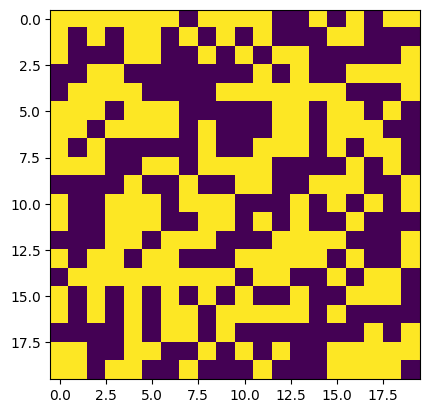

In [ ]:
plt.imshow(branch[0].reshape(20,20))

Sample #90 Relative L2 Error: 15.00%


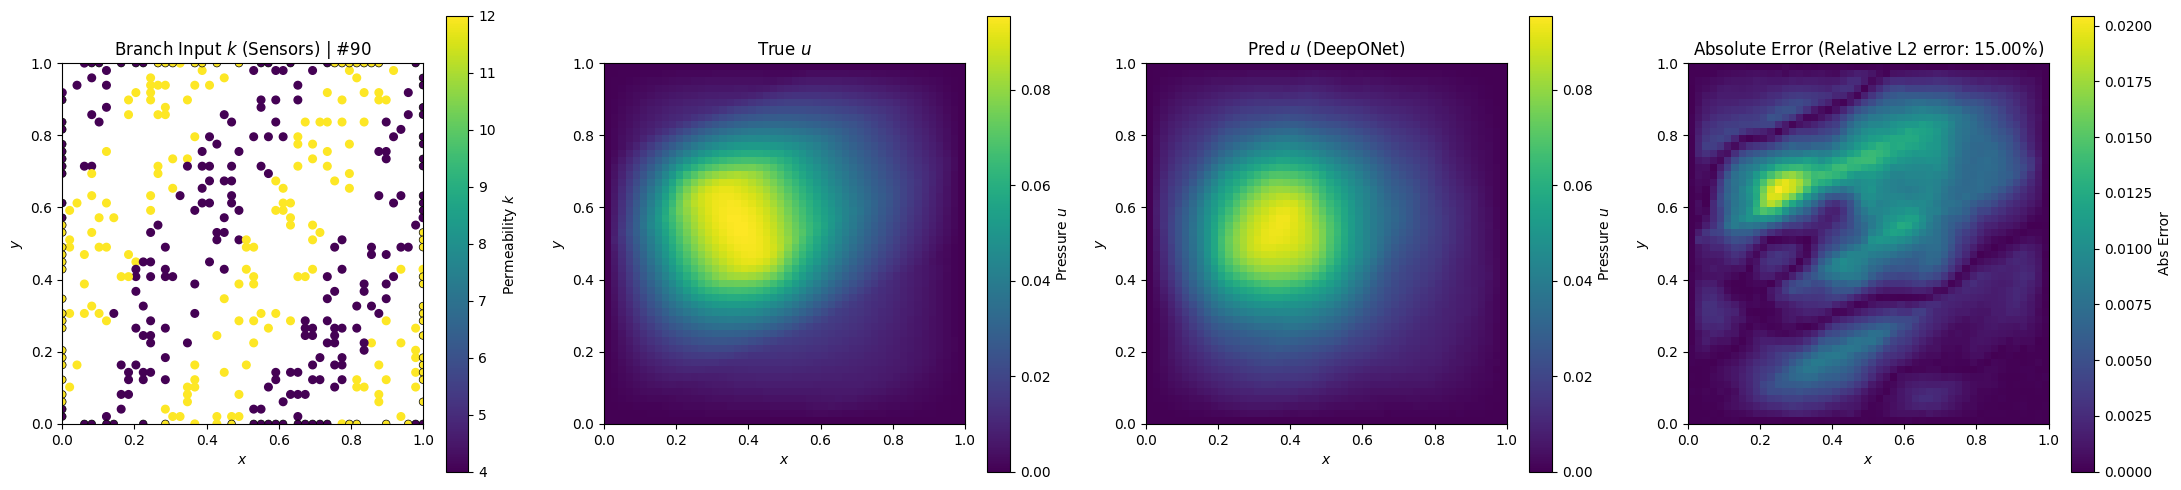

In [ ]:
# --- 1. 환경 설정 및 데이터 로드 ---
idx = 90
scale = 100.0  # 물리 스케일 복구 값
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 경로 (사용자 경로 유지)
data_path = "C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_bc.npz"
d = np.load(data_path, allow_pickle=True)

sensor_ij = d["sensor_ij"]       # Interior 센서 좌표 (indices)
bc_sensor_ij = d["bc_sensor_ij"] # Boundary 센서 좌표 (indices)
Nx, Ny = int(d["Nx"]), int(d["Ny"])

m = sensor_ij.shape[0]
b = bc_sensor_ij.shape[0]

# --- 2. 데이터 추출 및 모델 예측 ---
# Y, branch, trunk, model 등은 메모리에 정의되어 있다고 가정합니다.
with torch.no_grad():
    # True u 복구
    u_true = (Y[idx].detach().cpu().numpy() / scale).reshape(Nx, Ny)
    
    # Branch 입력 분리 (시각화용)
    k_sample = branch[idx].detach().cpu().numpy()
    k_interior = k_sample[:m]
    k_boundary = k_sample[m:m+b]
    
    # 모델 예측
    branch_input = branch[idx:idx+1].to(device)
    pred_scaled = model_mlp(branch_input)
    u_pred = (pred_scaled / scale).squeeze(0).detach().cpu().numpy().reshape(Nx, Ny)

# 오차 계산
u_err = np.abs(u_pred - u_true)

# --- 3. 시각화 설정 ---
v_min, v_max = u_true.min(), u_true.max()
e_min, e_max = 0.0, u_err.max()

# 좌표 정규화: 인덱스 (0 ~ N-1)를 (0.0 ~ 1.0)으로 변환
# 센서 좌표용
s_x, s_y = sensor_ij[:, 1] / (Ny - 1), sensor_ij[:, 0] / (Nx - 1)
bc_x, bc_y = bc_sensor_ij[:, 1] / (Ny - 1), bc_sensor_ij[:, 0] / (Nx - 1)

# imshow용 범위 [x_min, x_max, y_min, y_max]
extent_range = [0, 1, 0, 1]

# --- 4. Plot 생성 ---
plt.figure(figsize=(22, 5))

# 1) Branch Input (Sensors)
plt.subplot(1, 4, 1)
plt.title(f"Branch Input $k$ (Sensors) | #{idx}")
sc1 = plt.scatter(s_x, s_y, c=k_interior, cmap="viridis", s=30, label="Interior")
plt.scatter(bc_x, bc_y, c=k_boundary, cmap="viridis", s=30, edgecolors='black', linewidths=0.5, label="Boundary")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.gca().set_aspect("equal")
plt.colorbar(sc1, label="Permeability $k$")

# 2) True u
plt.subplot(1, 4, 2)
plt.title("True $u$")
im2 = plt.imshow(u_true.T, origin="lower", cmap="viridis", 
                 vmin=v_min, vmax=v_max, extent=extent_range, aspect="equal")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im2, label="Pressure $u$")

# 3) Pred u
plt.subplot(1, 4, 3)
plt.title("Pred $u$ (DeepONet)")
im3 = plt.imshow(u_pred.T, origin="lower", cmap="viridis", 
                 vmin=v_min, vmax=v_max, extent=extent_range, aspect="equal")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im3, label="Pressure $u$")


# 상대 오차 출력
rel_err = np.linalg.norm(u_true - u_pred) / (np.linalg.norm(u_true) + 1e-12) * 100
print(f"Sample #{idx} Relative L2 Error: {rel_err:.2f}%")

# 4) Absolute Error |Pred - True|
plt.subplot(1, 4, 4)
plt.title(f"Absolute Error (Relative L2 error: ${rel_err:.2f}$%)")
# 일반 스케일 imshow
im4 = plt.imshow(u_err.T, origin="lower", cmap="viridis", 
                 vmin=e_min, vmax=e_max, extent=extent_range, aspect="equal")

plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im4, label="Abs Error")

plt.tight_layout()

# --- 5. 결과 저장 및 출력 ---
save_path = f"C:/Users/admin/Desktop/김도형/코드/figure_20260206_labmeeting/MLP_sample_{idx}_result.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [43]:
d =  np.load("C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_grid_sensors.npz",allow_pickle=True)
branch_np, trunk_np, Y_np = d["branch"], d["trunk"], d["y"]

Y_np_scaled = Y_np * 100

branch   = convert_np_to_tensor(branch_np)
trunk   = convert_np_to_tensor(trunk_np)
Y = convert_np_to_tensor(Y_np_scaled)

print(f'branch shape: {branch.shape}, type: {type(branch)}, dtype: {branch.dtype}')
print(f'trunk shape: {trunk.shape}, type: {type(trunk)}, dtype: {trunk.dtype}')
print(f'Y shape: {Y.shape}, type: {type(Y)}, dtype: {Y.dtype}')

branch shape: torch.Size([100, 676]), type: <class 'torch.Tensor'>, dtype: torch.float64
trunk shape: torch.Size([2500, 2]), type: <class 'torch.Tensor'>, dtype: torch.float64
Y shape: torch.Size([100, 2500]), type: <class 'torch.Tensor'>, dtype: torch.float64


In [44]:
class Datahandler(Dataset):
  def __init__(self, u_branch, y_trunk, guy):
    self.u_branch = u_branch
    self.y_trunk = y_trunk
    self.guy = guy

  def __len__(self):
    return len(self.guy)

  def __getitem__(self, index):
    return self.u_branch[index,:], self.y_trunk, self.guy[index,:]

In [46]:
dataset = Datahandler(branch[:70], trunk, Y[:70])
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 70, shuffle=True)

In [47]:
class Network_grid(torch.nn.Module):
    def __init__(self, branch_dim=676, trunk_dim=2, hidden_dim=128, output_dim=64):
        super(Network_grid, self).__init__()

        self.bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.branch = nn.Sequential(
            nn.Linear(branch_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, branch, trunk):
        branch_out = self.branch(branch)
        trunk_out  = self.trunk(trunk)
        out = branch_out @ trunk_out.T + self.bias
        return out

def init_weights(m): 
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data) 
        nn.init.zeros_(m.bias)

In [48]:
model_grid = Network_grid()
model_grid.apply(init_weights)

Network_grid(
  (branch): Sequential(
    (0): Linear(in_features=676, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
)

In [49]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_grid.parameters(), lr=1e-4)
train_history = {'loss':[]}

In [51]:
n_epochs = 15000
for epoch in range(n_epochs):
  losses = []
  for branch_batch, _, Y_batch in dataloader: 
    optimizer.zero_grad()

    pred = model_grid(branch_batch, trunk)
    loss = loss_fn(pred, Y_batch)

    loss.backward()

    losses.append(loss.item())

    optimizer.step()

  avg_loss = np.mean(losses)
  if epoch%1000 == 0:
    print(f'Epoch: {epoch}, Loss: {float(avg_loss): .2}')

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- 1. 환경 설정 및 데이터 로드 ---
idx = 80
scale = 100.0  # 물리 스케일 복구 값
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 경로 (사용자 경로 유지)
data_path = "C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_grid_sensors.npz"
d = np.load(data_path, allow_pickle=True)

sensor_ij = d["sensor_ij"]   # grid 센서 좌표 (indices), shape (m,2)
Nx, Ny = int(d["Nx"]), int(d["Ny"])
m = sensor_ij.shape[0]

# (선택) 저장돼 있으면 읽어서 참고
include_boundary_sensors = bool(d["include_boundary_sensors"]) if "include_boundary_sensors" in d.files else False

# --- 2. 데이터 추출 및 모델 예측 ---
# Y, branch, trunk, model 등은 메모리에 정의되어 있다고 가정합니다.
model_grid.eval()
model_grid = model_grid.to(device)

with torch.no_grad():
    # True u 복구
    u_true = (Y[idx].detach().cpu().numpy() / scale).reshape(Nx, Ny)

    # Branch 입력 (grid sensors only)
    k_sample = branch[idx].detach().cpu().numpy()  # shape (m,)
    k_sensors = k_sample[:m]

    # 모델 예측
    branch_input = branch[idx:idx+1].to(device)  # (1,m)
    trunk_input = trunk.to(device)               # (Nx*Ny,2) or (1,N,2) depending on your model; keep as-is
    pred_scaled = model_grid(branch_input, trunk_input)
    u_pred = (pred_scaled / scale).squeeze(0).detach().cpu().numpy().reshape(Nx, Ny)

# 오차 계산
u_err = np.abs(u_pred - u_true)

# --- 3. 시각화 설정 ---
v_min, v_max = u_true.min(), u_true.max()
e_min, e_max = 0.0, u_err.max()

# 좌표 정규화: 인덱스 (0 ~ N-1)를 (0.0 ~ 1.0)으로 변환
# sensor_ij는 (i,j) = (x-index, y-index)
s_x = sensor_ij[:, 1] / (Ny - 1)  # x축(물리 x)에 해당하는 방향을 j로 쓰는 관례 유지
s_y = sensor_ij[:, 0] / (Nx - 1)

# imshow용 범위 [x_min, x_max, y_min, y_max]
extent_range = [0, 1, 0, 1]

# 상대 오차 (Relative L2)
rel_err = np.linalg.norm(u_true - u_pred) / (np.linalg.norm(u_true) + 1e-12) * 100
print(f"Sample #{idx} Relative L2 Error: {rel_err:.2f}%")

# --- 4. Plot 생성 ---
plt.figure(figsize=(22, 5))

# 1) Branch Input (Grid Sensors)
plt.subplot(1, 4, 1)
plt.title(f"Branch Input $k$ (Grid Sensors) | #{idx}\n(include_boundary={include_boundary_sensors})")
sc1 = plt.scatter(
    s_x, s_y,
    c=k_sensors,
    cmap="viridis",
    s=30
)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.gca().set_aspect("equal")
plt.colorbar(sc1, label="Permeability $k$")

# 2) True u
plt.subplot(1, 4, 2)
plt.title("True $u$")
im2 = plt.imshow(
    u_true.T,
    origin="lower",
    cmap="viridis",
    vmin=v_min, vmax=v_max,
    extent=extent_range,
    aspect="equal"
)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im2, label="Pressure $u$")

# 3) Pred u
plt.subplot(1, 4, 3)
plt.title("Pred $u$ (DeepONet)")
im3 = plt.imshow(
    u_pred.T,
    origin="lower",
    cmap="viridis",
    vmin=v_min, vmax=v_max,
    extent=extent_range,
    aspect="equal"
)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im3, label="Pressure $u$")

# 4) Absolute Error |Pred - True|
plt.subplot(1, 4, 4)
plt.title(f"Absolute Error (Rel L2: {rel_err:.2f}%)")
im4 = plt.imshow(
    u_err.T,
    origin="lower",
    cmap="viridis",
    vmin=e_min, vmax=e_max,
    extent=extent_range,
    aspect="equal"
)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im4, label="Abs Error")

plt.tight_layout()

# --- 5. 결과 저장 및 출력 ---
save_path = f"C:/Users/admin/Desktop/김도형/코드/figure_20260206_labmeeting/grid_sample_{idx}_result.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [26]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# ----------------------------
# Utilities
# ----------------------------
def convert_np_to_tensor(x: np.ndarray) -> torch.Tensor:
    return torch.from_numpy(x)

# ----------------------------
# Dataset
# ----------------------------
class Datahandler(Dataset):
    """
    branch: (N_samples, m_sensors)  # grid sensors flattened
    trunk : (N_points, 2)          # fixed for all samples
    guy   : (N_samples, N_points)  # solution flattened
    """
    def __init__(self, u_branch, y_trunk, guy):
        self.u_branch = u_branch
        self.y_trunk = y_trunk
        self.guy = guy

    def __len__(self):
        return self.guy.shape[0]

    def __getitem__(self, index):
        # trunk is shared (fixed)
        return self.u_branch[index, :], self.y_trunk, self.guy[index, :]

# ----------------------------
# CNN-Branch + MLP-Trunk DeepONet
# ----------------------------
class Network_grid_CNNBranch(nn.Module):
    """
    Assumes branch input corresponds to a regular grid of sensors:
      branch_flat shape: (B, m) where m = n_sx * n_sy
    We reshape to (B, 1, n_sx, n_sy) and feed CNN -> latent vector (p=output_dim).
    Trunk: standard MLP mapping (x,y)-> latent vector (p).
    Output: (B, N_points) via inner product.
    """
    def __init__(
        self,
        n_sx: int,
        n_sy: int,
        trunk_dim: int = 2,
        output_dim: int = 64,
        cnn_channels=(16, 32, 64),
        mlp_hidden: int = 64
    ):
        super().__init__()
        assert n_sx >= 2 and n_sy >= 2

        self.n_sx = n_sx
        self.n_sy = n_sy
        self.output_dim = output_dim

        self.bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        c1, c2, c3 = cnn_channels

        # Branch CNN: (B,1,n_sx,n_sy) -> (B, output_dim)
        self.branch_cnn = nn.Sequential(
            nn.Conv2d(1, c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # downsample

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # (B,c3,1,1)
            nn.Flatten(),
            nn.Linear(c3, output_dim)
        )

        # Trunk MLP: (N,2) -> (N, output_dim)
        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, output_dim)
        )

    def forward(self, branch_flat: torch.Tensor, trunk: torch.Tensor) -> torch.Tensor:
        """
        branch_flat: (B, n_sx*n_sy)
        trunk      : (N, 2)
        returns    : (B, N)
        """
        B = branch_flat.shape[0]
        if branch_flat.shape[1] != self.n_sx * self.n_sy:
            raise ValueError(
                f"branch dim mismatch: got {branch_flat.shape[1]}, expected {self.n_sx*self.n_sy} "
                f"(n_sx={self.n_sx}, n_sy={self.n_sy})"
            )

        branch_img = branch_flat.view(B, 1, self.n_sx, self.n_sy)
        branch_out = self.branch_cnn(branch_img)      # (B, p)
        trunk_out = self.trunk(trunk)                 # (N, p)

        out = branch_out @ trunk_out.T + self.bias    # (B, N)
        return out

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# ----------------------------
# Train script (structure kept close to yours)
# ----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    d = np.load(
        "C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_grid_sensors.npz",
        allow_pickle=True
    )
    branch_np, trunk_np, Y_np = d["branch"], d["trunk"], d["y"]

    # scale (keep your convention)
    Y_np_scaled = Y_np * 100

    branch = convert_np_to_tensor(branch_np).float().to(device)
    trunk = convert_np_to_tensor(trunk_np).float().to(device)
    Y = convert_np_to_tensor(Y_np_scaled).float().to(device)

    print(f"branch shape: {branch.shape}, dtype: {branch.dtype}")
    print(f"trunk  shape: {trunk.shape}, dtype: {trunk.dtype}")
    print(f"Y      shape: {Y.shape}, dtype: {Y.dtype}")

    # Infer (n_sx, n_sy) from saved metadata if available; otherwise assume square
    if "n_sx" in d.files and "n_sy" in d.files:
        n_sx = int(d["n_sx"])
        n_sy = int(d["n_sy"])
    else:
        m = branch.shape[1]
        s = int(round(m ** 0.5))
        if s * s != m:
            raise ValueError(
                "Cannot infer (n_sx,n_sy). Please store n_sx/n_sy in npz or set them manually."
            )
        n_sx, n_sy = s, s

    # Dataset / Dataloader
    dataset = Datahandler(branch[:70], trunk, Y[:70])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=35, shuffle=True)

    # Model
    model_grid = Network_grid_CNNBranch(
        n_sx=n_sx,
        n_sy=n_sy,
        trunk_dim=2,
        output_dim=64,
        cnn_channels=(16, 32, 64),
        mlp_hidden=64
    ).to(device)
    model_grid.apply(init_weights)

    # Optimizer / Loss
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model_grid.parameters(), lr=1e-4)

    # Train
    n_epochs = 10000
    for epoch in range(n_epochs):
        losses = []
        for branch_batch, _, Y_batch in dataloader:
            branch_batch = branch_batch.to(device)
            Y_batch = Y_batch.to(device)

            optimizer.zero_grad()
            pred = model_grid(branch_batch, trunk)   # trunk fixed (N,2)
            loss = loss_fn(pred, Y_batch)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if epoch % 1000 == 0:
            print(f"Epoch: {epoch}, Loss: {float(np.mean(losses)):.6f}")


branch shape: torch.Size([100, 676]), dtype: torch.float32
trunk  shape: torch.Size([2500, 2]), dtype: torch.float32
Y      shape: torch.Size([100, 2500]), dtype: torch.float32
Epoch: 0, Loss: 13.906585
Epoch: 1000, Loss: 0.236383


KeyboardInterrupt: 

Sample #80 Relative L2 Error: 42.83%


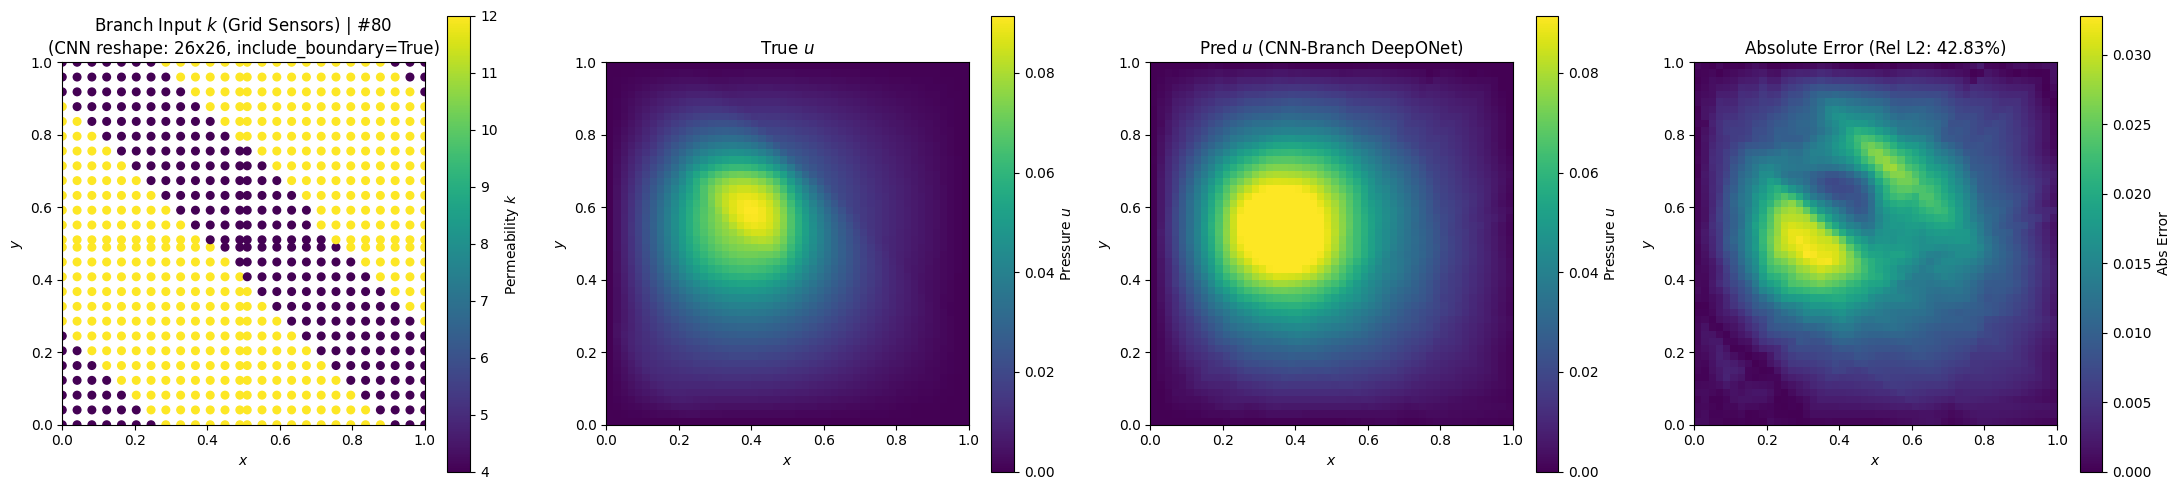

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- 1. 환경 설정 및 데이터 로드 ---
idx = 80
scale = 100.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "C:/Users/admin/Desktop/김도형/코드/Dataset/train_darcy_large_shape_grid_sensors.npz"
d = np.load(data_path, allow_pickle=True)

sensor_ij = d["sensor_ij"]  # (m,2)
Nx, Ny = int(d["Nx"]), int(d["Ny"])
m = sensor_ij.shape[0]

include_boundary_sensors = bool(d["include_boundary_sensors"]) if "include_boundary_sensors" in d.files else False

# CNN-branch용 (n_sx, n_sy) 읽기 (없으면 수동 지정/정사각 추정)
if "n_sx" in d.files and "n_sy" in d.files:
    n_sx = int(d["n_sx"])
    n_sy = int(d["n_sy"])
else:
    # 저장 안 돼 있으면 (예: 20x20이면 20,20으로 직접 넣는 게 가장 안전)
    s = int(round(m ** 0.5))
    if s * s != m:
        raise ValueError("Cannot infer (n_sx,n_sy). Please set n_sx,n_sy manually.")
    n_sx, n_sy = s, s

# --- 2. 데이터 추출 및 모델 예측 (CNN Branch DeepONet) ---
# branch, trunk, Y, model_grid (CNN버전) 이 메모리에 정의되어 있다고 가정
# model_grid: Network_grid_CNNBranch

model_grid.eval()
model_grid = model_grid.to(device)

with torch.no_grad():
    # True u 복구
    u_true = (Y[idx].detach().cpu().numpy() / scale).reshape(Nx, Ny)

    # branch 센서값(Flatten)
    k_sample = branch[idx].detach().cpu().numpy()  # (m,)
    k_sensors = k_sample[:m]

    # CNN 브랜치 입력 (1,m) -> 모델 내부에서 (1,1,n_sx,n_sy)로 reshape됨
    branch_input = branch[idx:idx+1].to(device)  # (1,m)

    # trunk는 (N,2)로 고정 입력
    trunk_input = trunk.to(device)

    pred_scaled = model_grid(branch_input, trunk_input)  # (1, N)
    u_pred = (pred_scaled / scale).squeeze(0).detach().cpu().numpy().reshape(Nx, Ny)

u_err = np.abs(u_pred - u_true)

# --- 3. 시각화 설정 ---
v_min, v_max = u_true.min(), u_true.max()
e_min, e_max = 0.0, u_err.max()

# 센서 좌표 정규화(산점도용): (i,j)->(x,y)
s_x = sensor_ij[:, 1] / (Ny - 1)
s_y = sensor_ij[:, 0] / (Nx - 1)

extent_range = [0, 1, 0, 1]

rel_err = np.linalg.norm(u_true - u_pred) / (np.linalg.norm(u_true) + 1e-12) * 100
print(f"Sample #{idx} Relative L2 Error: {rel_err:.2f}%")

# --- 4. Plot ---
plt.figure(figsize=(22, 5))

# 1) Branch Input (Grid Sensors) + CNN reshape 정보 표시
plt.subplot(1, 4, 1)
plt.title(
    f"Branch Input $k$ (Grid Sensors) | #{idx}\n"
    f"(CNN reshape: {n_sx}x{n_sy}, include_boundary={include_boundary_sensors})"
)
sc1 = plt.scatter(s_x, s_y, c=k_sensors, cmap="viridis", s=30)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.gca().set_aspect("equal")
plt.colorbar(sc1, label="Permeability $k$")

# 2) True u
plt.subplot(1, 4, 2)
plt.title("True $u$")
im2 = plt.imshow(
    u_true.T, origin="lower", cmap="viridis",
    vmin=v_min, vmax=v_max, extent=extent_range, aspect="equal"
)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im2, label="Pressure $u$")

# 3) Pred u (CNN-Branch DeepONet)
plt.subplot(1, 4, 3)
plt.title("Pred $u$ (CNN-Branch DeepONet)")
im3 = plt.imshow(
    u_pred.T, origin="lower", cmap="viridis",
    vmin=v_min, vmax=v_max, extent=extent_range, aspect="equal"
)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im3, label="Pressure $u$")

# 4) Absolute Error
plt.subplot(1, 4, 4)
plt.title(f"Absolute Error (Rel L2: {rel_err:.2f}%)")
im4 = plt.imshow(
    u_err.T, origin="lower", cmap="viridis",
    vmin=e_min, vmax=e_max, extent=extent_range, aspect="equal"
)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.colorbar(im4, label="Abs Error")

plt.tight_layout()

# --- 5. 저장 및 출력 ---
save_path = f"C:/Users/admin/Desktop/김도형/코드/figure_20260206_labmeeting/cnn_deeponet_grid_sample_{idx}_result.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


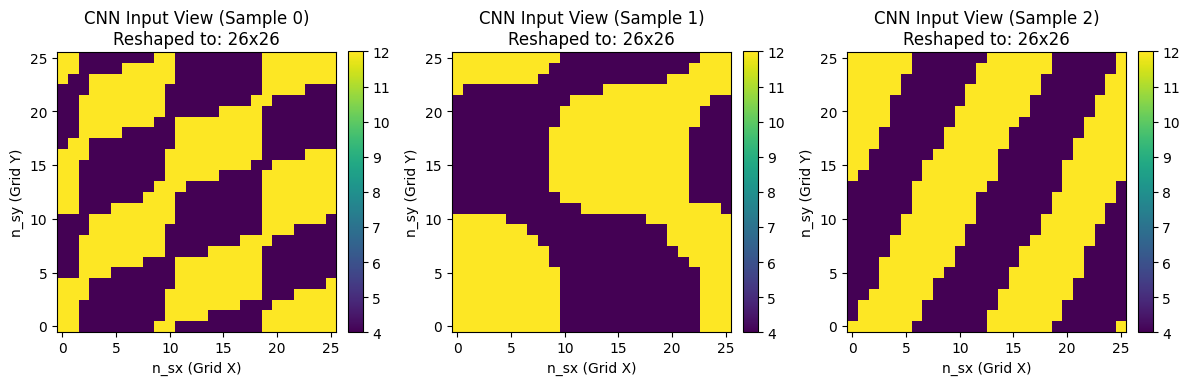

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_cnn_branch_input(model, dataloader, device, n_samples=3):
    model.eval()
    
    # 데이터로더에서 첫 번째 배치를 가져옵니다.
    branch_batch, _, _ = next(iter(dataloader))
    branch_batch = branch_batch.to(device)
    
    # 모델 내부의 reshape 로직을 수행합니다.
    # branch_flat: (B, n_sx * n_sy) -> branch_img: (B, 1, n_sx, n_sy)
    with torch.no_grad():
        B = branch_batch.shape[0]
        n_sx, n_sy = model.n_sx, model.n_sy
        branch_img = branch_batch.view(B, 1, n_sx, n_sy)
    
    # 시각화 시작
    samples_to_show = min(n_samples, B)
    fig, axes = plt.subplots(1, samples_to_show, figsize=(4 * samples_to_show, 4))
    
    if samples_to_show == 1:
        axes = [axes]

    for i in range(samples_to_show):
        # 텐서를 넘파이 배열로 변환 (C, H, W) -> (H, W)
        img_np = branch_img[i, 0].cpu().numpy()
        
        im = axes[i].imshow(img_np, cmap='viridis', origin='lower')
        axes[i].set_title(f"CNN Input View (Sample {i})\nReshaped to: {n_sx}x{n_sy}")
        axes[i].set_xlabel("n_sx (Grid X)")
        axes[i].set_ylabel("n_sy (Grid Y)")
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    plt.tight_layout()
    save_path = f"C:/Users/admin/Desktop/김도형/코드/figure_20260206_labmeeting/cnn_deeponet_branch_input.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# --- 실행 예시 (학습 코드 하단에 추가) ---
visualize_cnn_branch_input(model_grid, dataloader, device)